In [1]:
import numpy as np
import pandas as pd


# ============================================================
# 1) ほどよく複雑（でも読みやすい）な基底波形（seedで再現）
# ============================================================
def make_templates_simple(rng: np.random.Generator):
    # s1用の周波数成分（k）と振幅・位相をランダムに作る
    ks1 = np.array([1, 2, 3, 5])
    a1  = rng.uniform(0.08, 0.25, size=len(ks1)) / np.sqrt(ks1)
    p1  = rng.uniform(-np.pi, np.pi, size=len(ks1))

    # s3用（別の形にする）
    ks3 = np.array([1, 3, 4])
    a3  = rng.uniform(0.08, 0.22, size=len(ks3)) / np.sqrt(ks3)
    p3  = rng.uniform(-np.pi, np.pi, size=len(ks3))

    def z(theta):
        """
        s1の基底波形（θ → 波形値）
        ・複数の正弦波 + 少しだけ非線形（tanh）で形を作る
        """
        y = np.zeros_like(theta, dtype=float)
        for k, a, p in zip(ks1, a1, p1):
            y += a * np.sin(k * theta + p)
        # ちょい非線形成分（形を“それっぽく”する）
        y += 0.10 * np.tanh(2.0 * np.sin(theta - 0.2))
        return y

    def base_s3(theta):
        """
        s3の基底波形（別形）
        """
        y = np.zeros_like(theta, dtype=float)
        for k, a, p in zip(ks3, a3, p3):
            y += a * np.sin(k * theta + p)
        # 片側が少し強い形
        y += 0.08 * np.sin(theta) * np.abs(np.sin(theta))
        return y

    return z, base_s3


# ============================================================
# 2) 連続データを作り、先頭の正常区間から train を切り出し、
#    残りを test にしてCSV保存
#
# ★重要：phase（位相ズレ）は omega_scale ではなく theta_shift で表現
#   - omega_scale を変えると「周期の伸び縮み」になり、一定ラグではなくなる
#   - theta_shift を足すと「一定サンプルぶんの横ズレ」を作れる
# ============================================================
def make_periodic_3sensor_train_test_split_from_head_csv(
    out_train_csv="data_train.csv",
    out_test_csv="data_test.csv",
    out_full_csv=None,               # 連続全体も保存したい場合（例: "data_full.csv"）
    seed=0,
    samples_per_cycle=256,
    dt=0.01,
    rho_s1_s2=0.94,
    head_normal_cycles=300,          # 先頭の正常を長めに
    train_cycles=200,                # 先頭正常のうち train として使う周期数
    anomalies=None,                  # 例: [("freq_hf",30), ("shift",30), ("phase",30), ("freq_lf",30), ("spike",20)]
    gap_cycles=100,
    tail_normal_cycles=100,
    noise_std=0.02,
    anomaly_params=None,
    transition_cycles=2,             # 0なら段差切替、>0ならなめらか切替
    reset_test_time=True,            # testのtを0開始にする
    reset_test_cycle_id=True,        # testのcycle_idを0開始にする
    reset_test_segment=True,         # testのsegmentを0開始にする
):
    # 1周期のサンプル数（例：256）
    L = int(samples_per_cycle)

    # 角度θは 0→2π が1周期。1サンプル進むごとの基本増分。
    base_omega = 2.0 * np.pi / L

    # デフォルトの異常区間構成
    if anomalies is None:
        anomalies = [("freq_hf", 30), ("shift", 30), ("phase", 30), ("freq_lf", 30), ("spike", 20)]

    # 入力チェック
    if not (isinstance(head_normal_cycles, int) and head_normal_cycles > 0):
        raise ValueError("head_normal_cycles は正の整数にしてください。")
    if not (isinstance(train_cycles, int) and 1 <= train_cycles <= head_normal_cycles):
        raise ValueError("train_cycles は 1 以上で head_normal_cycles 以下にしてください。")

    # -----------------------------
    # センサ指定（dict/float/None）を統一して扱うための補助関数
    # -----------------------------
    def _to_sensor_dict(x, default=0.0):
        if x is None:
            v = float(default)
            return {"s1": v, "s2": v, "s3": v}
        if isinstance(x, (int, float)):
            v = float(x)
            return {"s1": v, "s2": v, "s3": v}
        return {"s1": float(x["s1"]), "s2": float(x["s2"]), "s3": float(x["s3"])}

    def _to_sensor_vec(x, default=0.0):
        d = _to_sensor_dict(x, default=default)
        return np.array([d["s1"], d["s2"], d["s3"]], dtype=float)

    # ノイズ標準偏差（センサごとにできる）
    noise_std = _to_sensor_dict(noise_std, default=0.02)

    # ラベル（整数化）
    label_int = {"normal": 0, "freq_hf": 1, "freq_lf": 1, "shift": 2, "phase": 3, "spike": 4}

    # -----------------------------
    # kindごとのデフォルトパラメータ
    #   omega_scale: θの進む速さ倍率（基本1.0）
    #   theta_shift: ★位相ズレ（θに足す定数）→ 一定ラグの横ズレになる
    #   shift      : 上下オフセット
    #   add_sin/scale: 周波数成分追加
    # -----------------------------
    defaults = {
        "normal": {
            "omega_scale": {"s1": 1.00, "s2": 1.00, "s3": 1.00},
            "theta_shift": {"s1": 0.0,  "s2": 0.0,  "s3": 0.0},   # ★追加
            "shift": {"s1": 0.0, "s2": 0.0, "s3": 0.0},
            "add_sin": [],
            "scale": {"s1": 0.0, "s2": 0.0, "s3": 0.0},
            "noise_std": None,
        },
        "freq_hf": {
            "omega_scale": {"s1": 1.00, "s2": 1.00, "s3": 1.00},
            "theta_shift": {"s1": 0.0,  "s2": 0.0,  "s3": 0.0},
            "shift": {"s1": 0.0, "s2": 0.0, "s3": 0.0},
            "add_sin": [(12, 0.18, 0.3), (18, 0.10, -1.0)],
            "scale": {"s1": 1.00, "s2": 0.95, "s3": 0.70},
            "noise_std": None,
        },
        "freq_lf": {
            "omega_scale": {"s1": 1.00, "s2": 1.00, "s3": 1.00},
            "theta_shift": {"s1": 0.0,  "s2": 0.0,  "s3": 0.0},
            "shift": {"s1": 0.0, "s2": 0.0, "s3": 0.0},
            "add_sin": [(0.5, 0.28, -0.4)],
            "scale": {"s1": 1.00, "s2": 0.95, "s3": 0.70},
            "noise_std": None,
        },
        "shift": {
            "omega_scale": {"s1": 1.00, "s2": 1.00, "s3": 1.00},
            "theta_shift": {"s1": 0.0,  "s2": 0.0,  "s3": 0.0},
            "shift": {"s1": 0.35, "s2": 0.35, "s3": 0.28},
            "add_sin": [],
            "scale": {"s1": 0.0, "s2": 0.0, "s3": 0.0},
            "noise_std": None,
        },
        "phase": {
            # ★一定ラグの横ズレを作りたいので omega_scale は 1.00 固定を推奨
            "omega_scale": {"s1": 1.00, "s2": 1.00, "s3": 1.00},
            # ★ここを anomaly_params で上書きして「特定センサだけ」ズラす
            "theta_shift": {"s1": 0.0,  "s2": 0.0,  "s3": 0.0},
            "shift": {"s1": 0.0, "s2": 0.0, "s3": 0.0},
            "add_sin": [],
            "scale": {"s1": 0.0, "s2": 0.0, "s3": 0.0},
            "noise_std": None,
        },
        "spike": {
            "omega_scale": {"s1": 1.00, "s2": 1.00, "s3": 1.00},
            "theta_shift": {"s1": 0.0,  "s2": 0.0,  "s3": 0.0},
            "shift": {"s1": 0.0, "s2": 0.0, "s3": 0.0},
            "add_sin": [],
            "scale": {"s1": 0.0, "s2": 0.0, "s3": 0.0},
            "noise_std": None,
        },
    }

    # ネストdictを上書きしやすいようにする（defaults を anomaly_params で部分上書き）
    def _deep_merge(a, b):
        if b is None:
            return a
        out = {}
        for k, v in a.items():
            out[k] = (v.copy() if isinstance(v, dict) else v)
        for k, v in b.items():
            if k in out and isinstance(out[k], dict) and isinstance(v, dict):
                out[k] = _deep_merge(out[k], v)
            else:
                out[k] = v
        return out

    anomaly_params = anomaly_params or {}
    params = {k: _deep_merge(defaults[k], anomaly_params.get(k, None)) for k in defaults}

    # -----------------------------
    # spike の個別設定（確率・振幅など）
    # -----------------------------
    sp_cfg = anomaly_params.get("spike", {}) or {}
    sp_expected = sp_cfg.get("expected_per_cycle", None)   # 1周期あたり期待スパイク数
    sp_prob = sp_cfg.get("prob_per_sample", 0.0)           # サンプルあたり確率
    sp_prob = float(sp_expected) / float(L) if (sp_expected is not None) else float(sp_prob)
    sp_prob = float(np.clip(sp_prob, 0.0, 1.0))
    sp_amp_std = float(sp_cfg.get("amp_std", 0.0))
    sp_scale = _to_sensor_vec(sp_cfg.get("scale", {"s1": 1.0, "s2": 1.0, "s3": 1.0}), default=1.0)
    sp_sign = str(sp_cfg.get("sign", "both"))              # positive/negative/both
    sp_shared = bool(sp_cfg.get("shared", False))          # Trueなら同じタイミングで複数センサに打つ

    # add_sin をまとめて「追加成分の種類（k, phase）」を統一管理
    def _collect_comp_keys(params_dict):
        keys = set()
        for kind in params_dict:
            for (k, amp, ph) in params_dict[kind]["add_sin"]:
                keys.add((float(k), float(ph)))
        return sorted(keys, key=lambda x: (x[0], x[1]))

    comp_keys = _collect_comp_keys(params)
    mcomp = len(comp_keys)

    # kindの目標パラメータ（3センサ分）を取り出す
    def _kind_targets(kind):
        pk = params[kind]

        # add_sin の振幅ベクトル（comp_keys順）
        amp_t = np.zeros(mcomp, dtype=float)
        amp_map = {(float(k), float(ph)): float(amp) for (k, amp, ph) in pk["add_sin"]}
        for j, key in enumerate(comp_keys):
            amp_t[j] = amp_map.get(key, 0.0)

        scale_t = _to_sensor_vec(pk["scale"], default=0.0)
        shift_t = _to_sensor_vec(pk["shift"], default=0.0)
        omega_t = _to_sensor_vec(pk["omega_scale"], default=1.0)

        # ★位相ズレ（θに足す定数）
        theta_t = _to_sensor_vec(pk.get("theta_shift", None), default=0.0)

        # noise_std（未指定なら global を使う）
        nk = pk.get("noise_std", None)
        nk = noise_std if nk is None else _to_sensor_dict(nk, default=0.02)
        noise_t = _to_sensor_vec(nk, default=0.02)

        return omega_t, theta_t, amp_t, scale_t, shift_t, noise_t

    # 遷移（なめらか切替）の係数
    tau = float(max(0, transition_cycles)) * float(L)
    a_const = 1.0 if tau <= 0 else (1.0 - float(np.exp(-1.0 / tau)))

    def _add_sin(theta, amp_vec):
        if mcomp == 0:
            return np.zeros_like(theta, dtype=float)
        y = np.zeros_like(theta, dtype=float)
        for j, (k, ph) in enumerate(comp_keys):
            y += float(amp_vec[j]) * np.sin(k * theta + ph)
        return y

    def _spike_value(rng, amp_std, sign):
        v = float(rng.normal(0.0, amp_std))
        if sign == "positive":
            return abs(v)
        if sign == "negative":
            return -abs(v)
        return v

    def _make_blocks():
        # 先頭は必ず normal を長く置く（train/testの分布差を減らす狙い）
        blocks = [("normal", int(head_normal_cycles))]

        # anomalies で指定した異常 → normal(gap) → 異常… の繰り返し
        for kind, n in anomalies:
            n = int(n)
            if n <= 0:
                continue
            blocks.append((str(kind), n))
            if int(gap_cycles) > 0:
                blocks.append(("normal", int(gap_cycles)))

        # 最後に normal を置きたいなら
        if int(tail_normal_cycles) > 0:
            blocks.append(("normal", int(tail_normal_cycles)))

        return blocks

    def _gen_one_series(blocks, rng_series, z, base_s3):
        # 連続全体のサンプル数
        total_cycles = int(sum(c for _, c in blocks))
        n = total_cycles * L

        # 区間ID、ラベル、kind名（サンプルごと）
        segment = np.empty(n, dtype=int)
        label = np.empty(n, dtype=int)
        kind_arr = np.empty(n, dtype=object)

        pos = 0
        seg_id = 0
        for kind, c in blocks:
            kind = str(kind)
            m = int(c) * L
            segment[pos:pos+m] = seg_id
            label[pos:pos+m] = int(label_int[kind])
            kind_arr[pos:pos+m] = kind
            pos += m
            seg_id += 1

        # s2を s1 と似せるための混合用の位相（固定）
        phi_u1 = float(rng_series.uniform(-np.pi, np.pi))
        phi_u3 = float(rng_series.uniform(-np.pi, np.pi))

        # 状態（なめらか遷移用）：最初のkindで初期化
        k0 = str(kind_arr[0])
        omega_s, theta_s, amp_s, scale_s, shift_s, noise_s = _kind_targets(k0)

        # 各センサの現在角度θ（時間で進むのはこれ）
        th = np.array([0.0, 0.0, 0.0], dtype=float)

        s1 = np.empty(n, dtype=float)
        s2 = np.empty(n, dtype=float)
        s3 = np.empty(n, dtype=float)

        eps = 1e-12

        for i in range(n):
            knd = str(kind_arr[i])
            omega_t, theta_t, amp_t, scale_t, shift_t, noise_t = _kind_targets(knd)

            # 状態を目標へなめらかに近づける（transition_cycles=0なら即時切替）
            omega_s = omega_s + a_const * (omega_t - omega_s)
            theta_s = theta_s + a_const * (theta_t - theta_s)   # ★位相ズレもなめらかに切替可
            amp_s   = amp_s   + a_const * (amp_t   - amp_s)
            scale_s = scale_s + a_const * (scale_t - scale_s)
            shift_s = shift_s + a_const * (shift_t - shift_s)
            noise_s = noise_s + a_const * (noise_t - noise_s)

            # 現在の角度θ（進むのはth）
            th1, th2, th3 = th[0], th[1], th[2]

            # ★評価用の角度：ここに theta_shift を足す
            #   これにより「一定サンプル分の横ズレ（一定ラグ）」が作れる
            th1e = th1 + theta_s[0]
            th2e = th2 + theta_s[1]   # ← s2だけズラしたいなら theta_s[1] だけ非ゼロにする
            th3e = th3 + theta_s[2]

            # 基底波形
            s1_i = z(np.array([th1e]))[0]
            s3_i = base_s3(np.array([th3e]))[0]

            # s2 は s1 っぽい成分 + 別成分 u の混合
            u_i  = z(np.array([th2e + phi_u1]))[0] + 0.6 * base_s3(np.array([th2e + phi_u3]))[0]
            s2_i = float(rho_s1_s2) * s1_i + float(1.0 - rho_s1_s2) * u_i

            # 追加周波数成分（add_sin）
            add1 = _add_sin(np.array([th1e]), amp_s)[0]
            add2 = _add_sin(np.array([th2e]), amp_s)[0]
            add3 = _add_sin(np.array([th3e]), amp_s)[0]

            # スケール付き追加成分 + 上下シフト
            s1_i = s1_i + scale_s[0] * add1 + shift_s[0]
            s2_i = s2_i + scale_s[1] * add2 + shift_s[1]
            s3_i = s3_i + scale_s[2] * add3 + shift_s[2]

            # スパイク（kind == spike のときのみ）
            if knd == "spike" and sp_prob > 0.0 and sp_amp_std > 0.0:
                if sp_shared:
                    # 同じタイミングで複数センサへ
                    if rng_series.random() < sp_prob:
                        v = _spike_value(rng_series, sp_amp_std, sp_sign)
                        if abs(sp_scale[0]) > eps: s1_i += sp_scale[0] * v
                        if abs(sp_scale[1]) > eps: s2_i += sp_scale[1] * v
                        if abs(sp_scale[2]) > eps: s3_i += sp_scale[2] * v
                else:
                    # センサごとに独立
                    if abs(sp_scale[0]) > eps and (rng_series.random() < sp_prob):
                        s1_i += sp_scale[0] * _spike_value(rng_series, sp_amp_std, sp_sign)
                    if abs(sp_scale[1]) > eps and (rng_series.random() < sp_prob):
                        s2_i += sp_scale[1] * _spike_value(rng_series, sp_amp_std, sp_sign)
                    if abs(sp_scale[2]) > eps and (rng_series.random() < sp_prob):
                        s3_i += sp_scale[2] * _spike_value(rng_series, sp_amp_std, sp_sign)

            # ノイズを加える
            s1_i += rng_series.normal(0.0, noise_s[0])
            s2_i += rng_series.normal(0.0, noise_s[1])
            s3_i += rng_series.normal(0.0, noise_s[2])

            s1[i], s2[i], s3[i] = s1_i, s2_i, s3_i

            # ★θを進める（ここは omega_scale で周期の伸び縮みになる）
            th = th + base_omega * omega_s

        # 時刻と周期内サンプル番号など（便利列）
        t = np.arange(n, dtype=float) * float(dt)
        cycle_id = (np.arange(n) // L).astype(int)
        sample_in_cycle = (np.arange(n) % L).astype(int)

        return pd.DataFrame({
            "t": t,
            "s1": s1,
            "s2": s2,
            "s3": s3,
            "segment": segment,
            "label": label,
            "cycle_id": cycle_id,
            "sample_in_cycle": sample_in_cycle,
        })

    # --- 基底生成（seedで再現）
    rng_base = np.random.default_rng(seed)
    z, base_s3 = make_templates_simple(rng_base)

    # --- 連続データ生成
    rng_series = np.random.default_rng(seed + 1)
    blocks = _make_blocks()
    df_full = _gen_one_series(blocks, rng_series, z, base_s3)

    # --- 先頭の正常区間の一部を train として切り出す
    train_end = int(train_cycles) * L
    df_train = df_full.iloc[:train_end].copy()
    df_test  = df_full.iloc[train_end:].copy()

    # --- test側の列を 0 始まりに直す（ファイル単体で扱いやすくする）
    if reset_test_time and ("t" in df_test.columns):
        df_test["t"] = df_test["t"] - float(df_test["t"].iloc[0])
    if reset_test_cycle_id and ("cycle_id" in df_test.columns):
        df_test["cycle_id"] = df_test["cycle_id"] - int(df_test["cycle_id"].iloc[0])
    if reset_test_segment and ("segment" in df_test.columns):
        df_test["segment"] = df_test["segment"] - int(df_test["segment"].iloc[0])

    # --- 保存
    df_train.to_csv(out_train_csv, index=False, encoding="utf-8-sig")
    df_test.to_csv(out_test_csv, index=False, encoding="utf-8-sig")
    if out_full_csv is not None:
        df_full.to_csv(out_full_csv, index=False, encoding="utf-8-sig")

    return df_train, df_test, df_full, out_train_csv, out_test_csv, out_full_csv




# anomaly_params（設定項目の整理：コピペ用）

## 全体の形
anomaly_params は「異常タイプごとの設定」をまとめた辞書です。  
キーは `"freq_hf"`, `"shift"`, `"phase"`, `"spike"` など。

---

## 1) freq_hf（周波数成分の追加：高周波側の想定）
### 設定項目
- add_sin  
  形式：[(k, amp, phase), (k, amp, phase), ...]  
  意味：sin(k * θ + phase) を amp 倍で足す成分のリスト  
  - k：1サイクル中に何回振動するか（整数が基本。3なら「1サイクルで3回うねる」）
  - amp：追加する成分の強さ
  - phase：位相（ラジアン）
- scale  
  形式：{"s1":数値, "s2":数値, "s3":数値}  
  意味：add_sin で作った追加波形を各センサに何倍で入れるか  
  - s1=1.00, s2=0.98 なら s2もほぼ同じ強さで追加
  - s3=0.60 なら s3は弱めに追加

あなたの設定：
- add_sin = [(3, 0.25, 0.3)]
- scale   = {"s1":1.00,"s2":0.98,"s3":0.60}

---

## 2) shift（上下シフト）
### 設定項目
- shift  
  形式：{"s1":数値, "s2":数値, "s3":数値}  
  意味：センサごとに値を一定量だけ足す（平均がずれる）

あなたの設定：
- shift = {"s1":0.50,"s2":0.0,"s3":-0.10}

---

## 3) phase（位相ズレ：連続θのまま進み方を変える）
### 設定項目
- omega_scale  
  形式：{"s1":数値, "s2":数値, "s3":数値}  
  意味：θ の進む速さの倍率（= 見かけの周波数の倍率）  
  - 1.00：正常と同じ
  - 1.03：少し速い → 時間が経つほど位相が先行
  - 0.97：少し遅い → 時間が経つほど位相が遅れる

注意（重要）：
- 0以下（例：-0.7）は「θが逆向きに進む」ので波形が反転方向に走ります。  
  一般に「位相ズレ目的」なら 0.8〜1.2 程度が無難です。
- 1.5 はかなり速い（1サイクルが短くなる）ので意図が「強いズレ」ならOK。

あなたの設定：
- omega_scale = {"s1":1.5,"s2":1.00,"s3":-0.7}

---

## 4) spike（たまにピーク/外れ値）
### 設定項目
- expected_per_cycle  
  形式：数値（例：1）  
  意味：1サイクルあたりの平均発生回数（期待値）。発生タイミングはランダム。
- amp_std  
  形式：数値（例：0.9）  
  意味：ピークの大きさ（標準偏差）。大きいほど派手。
- scale  
  形式：{"s1":数値,"s2":数値,"s3":数値}  
  意味：ピーク値 v を各センサに「倍率×v」で入れる  
  - 0 にするとそのセンサにはピークを入れない
- sign  
  "both" / "positive" / "negative"  
  意味：
  - both：正負どちらも（平均0の外れ値）
  - positive：正方向だけ（ピークっぽい）
  - negative：負方向だけ
- shared  
  true / false  
  意味：
  - true：同じ時刻に3センサ同時ピーク（共通原因っぽい）
  - false：センサごとに独立にピーク（バラける）

あなたの設定：
- expected_per_cycle = 1
- amp_std = 0.9
- scale = {"s1":1.0,"s2":0,"s3":1}
- sign = "positive"
- shared = False



In [2]:
# ============================================================
# 実行例（ここだけ変えればOK）※ phase は「位相ズレだけ」
# （Notebook想定：if __name__ == "__main__": は使わない）
# ============================================================

# -----------------------------
# 位相ズレ量の指定（サンプル数で指定）
#   例: +20 サンプルぶん右にずらす
# -----------------------------
PHASE_SHIFT_SAMPLES = 30
L = 256  # samples_per_cycle と一致させる

# サンプル数のズレを「角度θのズレ」に変換
# 1周期=2π、Lサンプルで1周期 → 1サンプルあたり 2π/L
theta = 2.0 * np.pi * (PHASE_SHIFT_SAMPLES / L)

# -----------------------------
# 異常パラメータ
#   - phase は omega_scale ではなく theta_shift を使う
#   - s2 だけズラす例
# -----------------------------
anomaly_params = {
    "freq_hf": {
        "add_sin": [(3, 0.25, 0.3)],
        "scale": {"s1": 1.00, "s2": 0.98, "s3": 0.60},
    },
    "shift": {
        "shift": {"s1": 0.50, "s2": 0.0, "s3": -0.10},
    },
    "phase": {
        # ★一定ラグ（横ズレ）だけ
        "theta_shift": {"s1": 0.0, "s2": theta, "s3": 0.0},
    },
    "spike": {
        "expected_per_cycle": 1.0,
        "amp_std": 0.9,
        "scale": {"s1": 1.00, "s2": 0.0, "s3": 1.0},
        "sign": "positive",
        "shared": False,
    },
}

# -----------------------------
# 生成設定
# -----------------------------
head_normal_cycles = 1500
train_cycles = 1000

# 異常→正常(gap)→異常… の並び
anomalies = [("freq_hf", 100), ("shift", 100), ("phase", 100), ("spike", 100)]
gap_cycles = 100
tail_normal_cycles = 100

# 0: 段差切替、>0: なめらか切替（位相ズレもなめらかに変化する）
transition_cycles = 1

# 生成
df_train, df_test, df_full, train_csv, test_csv, full_csv = make_periodic_3sensor_train_test_split_from_head_csv(
    out_train_csv="data_train_Smooth.csv",
    out_test_csv="data_test_Smooth.csv",
    out_full_csv=None,

    seed=0,
    samples_per_cycle=L,
    dt=0.01,
    rho_s1_s2=0.05,

    head_normal_cycles=head_normal_cycles,
    train_cycles=train_cycles,

    anomalies=anomalies,
    gap_cycles=gap_cycles,
    tail_normal_cycles=tail_normal_cycles,

    noise_std=0.1,
    anomaly_params=anomaly_params,
    transition_cycles=transition_cycles,

    reset_test_time=True,
    reset_test_cycle_id=True,
    reset_test_segment=True,
)

print("saved:", train_csv, test_csv)
print("train:", df_train.shape, "test:", df_test.shape, "full:", df_full.shape)
print(f"phase shift: {PHASE_SHIFT_SAMPLES} samples (= {theta:.6f} rad), target sensor: s2 only")


saved: data_train_Smooth.csv data_test_Smooth.csv
train: (256000, 8) test: (358400, 8) full: (614400, 8)
phase shift: 30 samples (= 0.736311 rad), target sensor: s2 only


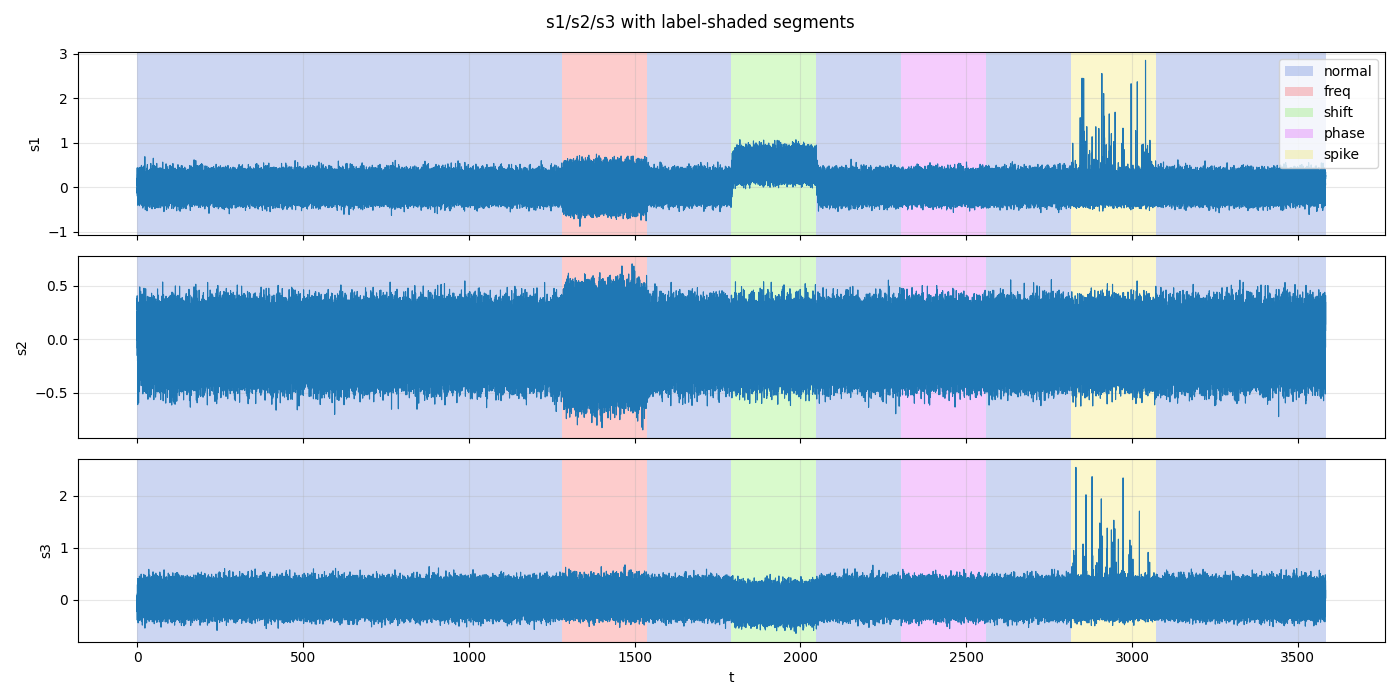

In [3]:
%matplotlib widget
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# 設定（必要ならここだけ変更）
# =========================
CSV_PATH = "data_test_Smooth.csv"   # 生成したテストデータ
X_COL = "t"
SEG_COL = "segment"
LBL_COL = "label"            # ★ラベル列は1つ
SENSOR_COLS = ["s1", "s2", "s3"]

DOWNSAMPLE_STEP = 1          # 重いなら 5, 10 などに
SPAN_ALPHA = 0.20

# labelごとの背景色（必要なら変える）
LABEL_COLOR = {
    0: "#0033c0ce",  # normal
    1: "#f80000",    # freq (freq_hf / freq_lf)
    2: "#41e600",    # shift
    3: "#cf00f8",    # phase
    4: "#ebdb00",    # spike
}

LABEL_NAME = {
    0: "normal",
    1: "freq",
    2: "shift",
    3: "phase",
    4: "spike",
}

# =========================
# 読み込み
# =========================
df = pd.read_csv(CSV_PATH)

# 必須列チェック
need = [X_COL, SEG_COL, LBL_COL] + SENSOR_COLS
miss = [c for c in need if c not in df.columns]
if miss:
    raise ValueError(f"CSVに必要列がありません: {miss}\nCSVの列: {df.columns.tolist()}")

# 型そろえ
df[X_COL] = df[X_COL].astype(float)
df[SEG_COL] = df[SEG_COL].astype(int)
df[LBL_COL] = df[LBL_COL].astype(int)

# =========================
# segment の連続区間（開始/終了）を抽出
# 背景色は「区間のlabel」で決める
# =========================
x = df[X_COL].to_numpy()
seg = df[SEG_COL].to_numpy()
lbl = df[LBL_COL].to_numpy()

change = np.r_[True, seg[1:] != seg[:-1]]
start_idx = np.flatnonzero(change)
end_idx = np.r_[start_idx[1:], len(df)] - 1

# 右端を少し伸ばす（tが連続値なので +1 ではなく dt相当を足す）
dx = float(np.median(np.diff(x))) if len(x) >= 2 else 1.0
x_starts = x[start_idx]
x_ends   = x[end_idx] + dx
seg_lbls = lbl[start_idx]  # 各segmentのlabel（segment内は一定の前提）

# =========================
# プロット（センサごと縦タイル）
# =========================
fig, axes = plt.subplots(nrows=len(SENSOR_COLS), ncols=1, figsize=(14, 7), sharex=True)

# 背景（segmentごとに塗る）
for xs, xe, lab in zip(x_starts, x_ends, seg_lbls):
    color = LABEL_COLOR.get(int(lab), "white")
    for ax in axes:
        ax.axvspan(xs, xe, alpha=SPAN_ALPHA, color=color, linewidth=0)

# 折れ線（必要なら間引き）
idx = np.arange(0, len(df), DOWNSAMPLE_STEP)
x_plot = df.loc[idx, X_COL].to_numpy()

for ax, col in zip(axes, SENSOR_COLS):
    y_plot = df.loc[idx, col].to_numpy()
    ax.plot(x_plot, y_plot, linewidth=0.8)
    ax.set_ylabel(col)
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel(X_COL)
fig.suptitle("s1/s2/s3 with label-shaded segments", y=0.98)

# 凡例（背景色の意味）
unique_labs = sorted(set(int(v) for v in seg_lbls.tolist()))
handles, labels = [], []
for lab in unique_labs:
    c = LABEL_COLOR.get(int(lab), "white")
    patch = plt.Rectangle((0, 0), 1, 1, facecolor=c, alpha=SPAN_ALPHA, edgecolor="none")
    handles.append(patch)
    labels.append(LABEL_NAME.get(int(lab), f"label={int(lab)}"))
axes[0].legend(handles, labels, loc="upper right")

plt.tight_layout()
plt.show()
